# Nuclei detection

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scout import io
from scout import utils
from scout import plot
from scout.detection import nucleus_probability
from scout.detection import detect_nuclei_parallel

In [2]:
%matplotlib notebook

## Select working directory for current organoid

In [3]:
parent_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping'
# folder_name = '20190430_11_36_09_AA-4.30.19-org1_488LP12p5_561LP120_642LP50'
folder_name = '20190509_16_55_31_AA-orgs5.8.19_org1_488LP15_561LP140_642LP50'
working_dir = os.path.join(parent_dir, folder_name)
os.listdir(working_dir)

['sox2.zarr', 'tbr1.zarr', 'syto.zarr']

## Set parameters on test images

In [4]:
syto_path = 'syto.zarr'

syto_zarr = io.open(os.path.join(working_dir, syto_path))
syto_zarr.shape

(1200, 9032, 7286)

In [31]:
# extract test patch
shape = np.array((256, 256, 256))
start = np.array((256, 1024, 2048))

stop = start + shape
syto_test = utils.extract_box(syto_zarr, start, stop)
syto_test.shape

(256, 256, 256)

<IPython.core.display.Javascript object>


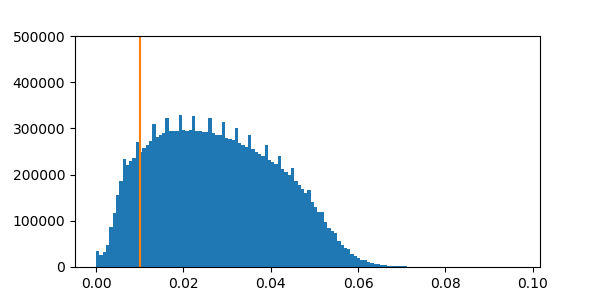

In [32]:
# Set threshold for nuclei detection
min_intensity = 0.01

ymax = 500000
plt.figure(figsize=(6, 3))
plt.hist(syto_test.ravel(), bins=128)
plt.plot([min_intensity, min_intensity], [0, ymax])
plt.ylim([0, ymax])
plt.show()

<IPython.core.display.Javascript object>


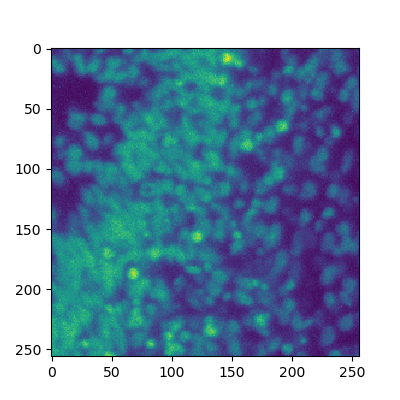

In [34]:
# test image
plt.figure(figsize=(4, 4))
plt.imshow(syto_test[64])
plt.show()

In [49]:
sigma = (1.0, 3.0, 3.0)
steepness = 1800
offset = -0.0005
I0 = 1
stdev = 0.02

prob = nucleus_probability(syto_test, sigma, steepness, offset, I0, stdev)

<IPython.core.display.Javascript object>


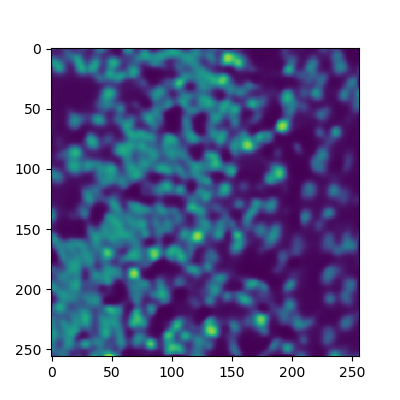

In [50]:
# Probability map
plt.figure(figsize=(4, 4))
plt.imshow(prob[64], clim=[0, 1])
plt.show()

## Detect nuclei in whole organoid

In [51]:
prob_path = 'nuclei_probability.zarr'
chunks = (64, 64, 64)
min_dist = 2
prob_thresh = 0.2
overlap = 8
nb_workers = 1  # One worker is GPU

prob_output = io.new_zarr(os.path.join(working_dir, prob_path), 
                          syto_zarr.shape, 
                          syto_zarr.chunks,
                          np.float32)

# GPU runtime error fixed by installing pytorch-nightly build
results = detect_nuclei_parallel(syto_zarr, 
                                 sigma=sigma, 
                                 min_intensity=min_intensity,
                                 steepness=steepness, 
                                 offset=offset,
                                 I0=I0,
                                 stdev=stdev,
                                 prob_thresh=prob_thresh,
                                 min_dist=min_dist,
                                 chunks=chunks,
                                 overlap=overlap,
                                 nb_workers=nb_workers,
                                 prob_output=prob_output)
centers_list = [r for r in results if r is not None]

  0%|          | 176/307572 [00:01<51:07, 100.21it/s]/home/jswaney/anaconda3/envs/scout/lib/python3.6/site-packages/skimage/feature/peak.py:189: RuntimeWarning: invalid value encountered in greater
  mask &= image > max(thresholds)
100%|██████████| 307572/307572 [4:26:18<00:00, 19.25it/s]   


In [52]:
centers = np.vstack(centers_list)  # Make coordinates array (Nx3)
centers.shape

(8821701, 3)

## Check the results

<IPython.core.display.Javascript object>


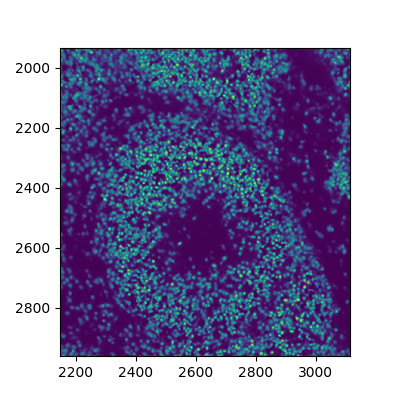

In [53]:
# check that the probability map was saved properly
plt.figure(figsize=(4, 4))
plt.imshow(prob_output[400], clim=[0, 1])
plt.show()

<IPython.core.display.Javascript object>


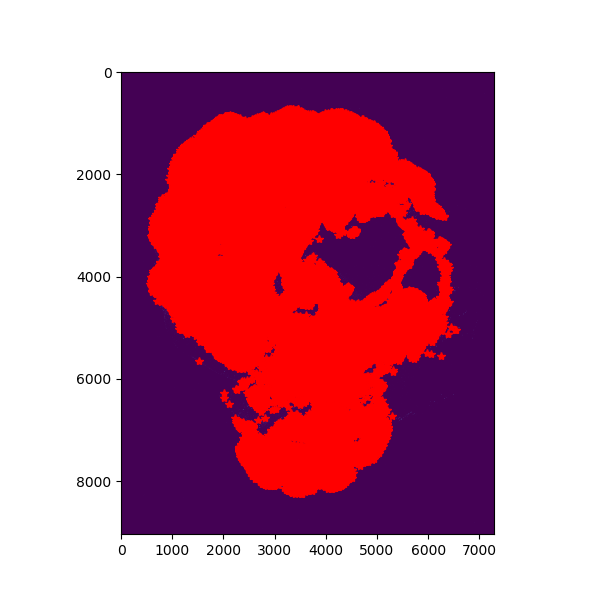

In [54]:
# Show detections overlay
plt.figure(figsize=(6, 6))
plot.zprojection(syto_zarr, centers, zlim=[400, 405])

## Save the results

In [55]:
centers_path = 'centroids.npy'

np.save(os.path.join(working_dir, centers_path), centers)

In [57]:
from scout.utils import read_voxel_size

In [59]:
voxel_size = utils.read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))
centroids_um = centers * np.asarray(voxel_size)

In [60]:
centers_um_path = 'centroids_um.npy'

np.save(os.path.join(working_dir, centers_um_path), centroids_um)

# Save an ROI for manual annotation

Do this in ImageJ...